In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

깊은 DNN 모델을 학습시키면 다음과 같은 문제가 나타날 수 있다.  

- **그래디언트 소실**(vanishing gradient) 또는 **폭주**(exploding)가 발생할 수 있다.
- 모델이 복잡하고 커질수록 **학습시간이 매우 느려진다**.
- 모델이 복잡할수록 **오버피팅(overfitting)** 될 위험이 크다.

## 11.1 그래디언트 소실과 폭주 문제

역전파 알고리즘은 출력층(output layer)에서 입력층(input layer)로 오차 그래디언트(gradient)를 흘려 보내면서 각 뉴런의 입력값에 대한 손실함수의 그래디언트를 계산한다. 이렇게 계산된 그래디언트를 경사 하강법(gradient descent)단계에서 각 가중치 매개변수( 𝐖
 )를 업데이트 해준다.

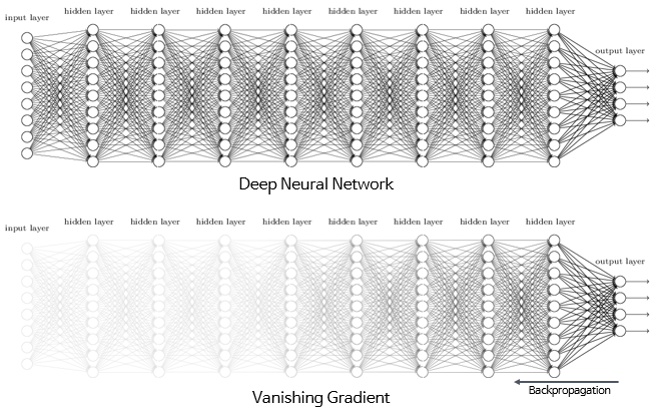

위의 그림과 같이 깊이가 깊은 심층신경망에서는 역전파 알고리즘이 입력층으로 전달됨에 따라 그래디언트가 점점 작아져 결국 가중치 매개변수가 업데이트 되지 않는 경우가 발생하게 된다. 이러한 문제를 **그래디언트 소실(vanishing gradient)** 라고 한다.  

그래디언트 소실과는 반대로 역전파에서 그래디언트가 점점 커져 입력층으로 갈수록 가중치 매개변수가 기하급수적으로 커지게 되는 경우가 있는데 이를 **그래디언트 폭주(exploding gradient)** 라고 하며, 이 경우에는 발산(diverse)하게되어 학습이 제대로 이루어지지 않는다.

기울기 소실의 발생 원인은 활성화 함수(Activation Function)의 기울기와 관련이 깊다.

예를 들면, 시그모이드 함수에서  
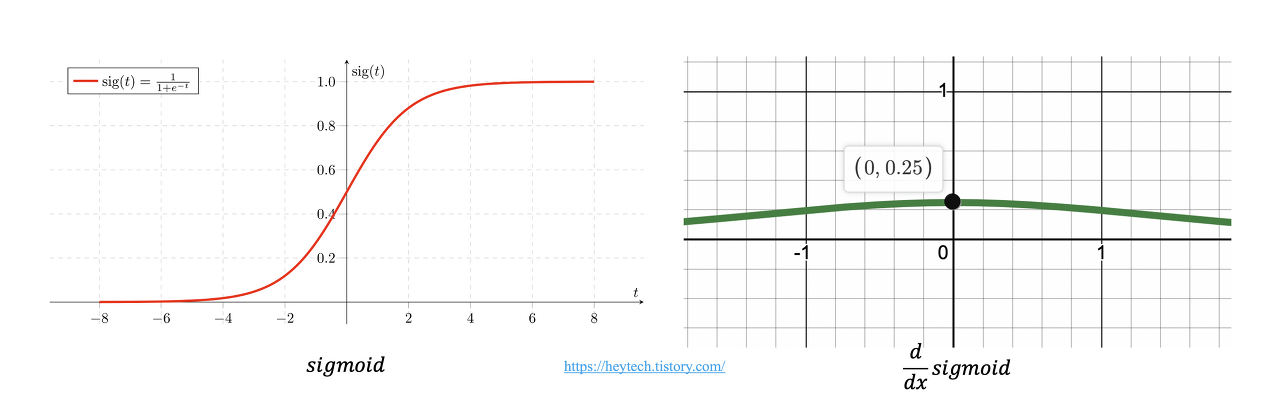  

시그모이드 함수의 미분 값은 입력 값이 0일 때 가장 크지만 0.25에 불과하고,  
x값이 크거나 작아짐에 따라 기울기는 거의 0에 수렴하는 것을 확인하실 수 있다.  
따라서, 역전파 과정에서 시그모이드 함수의 미분값이 거듭 곱해지면 출력층과 멀어질수록 Gradient 값이 매우 작아질 수밖에 없습니다

### 11.1.1 글로럿과 He 초기화

적절한 신호가 흐르기 위해서는 각 층의 출력에 대한 분산이 입력에 대한 분산과 같아야 하고  
역방향에서 층을 통과하기 전과 후의 그레디언트 분산이 동일해야 한다.  
사실 층의 입력과 출력 연결 개수(층의 팬-인, 팬-아웃 이라고 부름)가 같지 않다면 위 두 가지를 보장할 수 없다.  
하지만 각 층의 연결 가중치를 무작위로 초기화하여 구현  

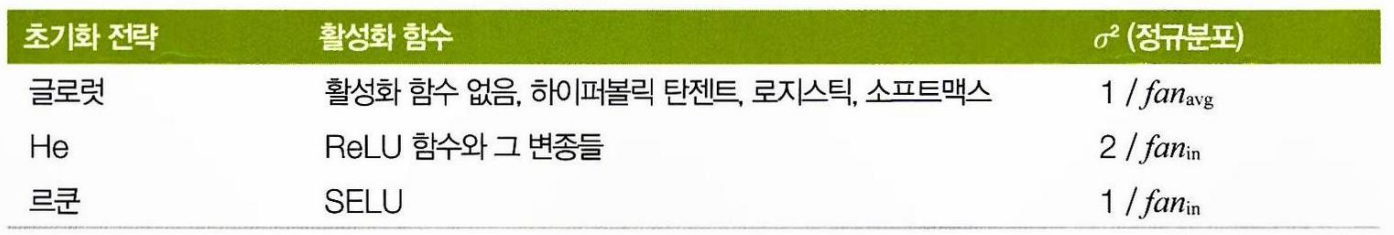

케라스는 기본적으로 균등분포 글로럿 초기화를 사용  

In [5]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

kernel_initializer="he_normal" 을 사용해 He 초기화 사용

In [6]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

fan_in 대신 fan_avg 기반의 He 초기화를 사용하고 싶다면 Variance Scaling 사용 가능

In [7]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

### 11.1.2 수렴하지 않는 활성화 함수

ReLU 함수는 특정 양수값에 수렴하지 않는다(계산도 빠르다)  
그러나 죽은 ReLU문제가 있어 **LeakyReLU** 등장

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'mish',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

#### LeakyReLU를 사용해 패션 MNIST에서 신경망을 훈련

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [14]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [15]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 1.2430 - accuracy: 0.6245 - val_loss: 0.8706 - val_accuracy: 0.7266
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7914 - accuracy: 0.7406 - val_loss: 0.7097 - val_accuracy: 0.7652
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6820 - accuracy: 0.7746 - val_loss: 0.6421 - val_accuracy: 0.7894
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6229 - accuracy: 0.7944 - val_loss: 0.5904 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5843 - accuracy: 0.8056 - val_loss: 0.5589 - val_accuracy: 0.8150
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5566 - accuracy: 0.8139 - val_loss: 0.5353 - val_accuracy: 0.8210
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5356 - accuracy: 0.8195 - val_loss: 0.5158 - val_accuracy:

#### ELU  
훈련 시간이 줄고 신경망의 테스트 세트 성능도 더 높았다.  
그러나 주요 단점은 (지수 함수를 사용하므로) ReLU나 그 변종들보다 계산이 느리다.

In [16]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

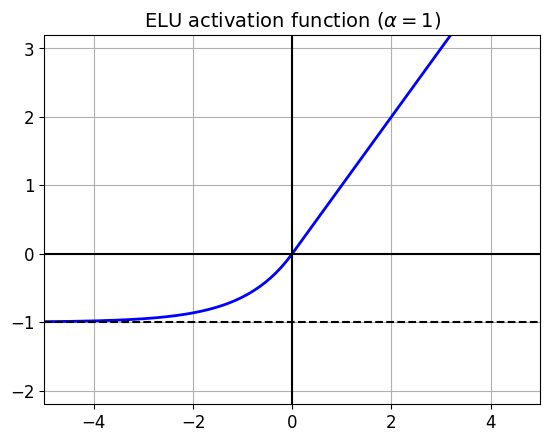

In [19]:
z = np.linspace(-5, 5, 200)

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [20]:
keras.layers.Dense(10, activation="elu")

#### SELU  
훈련하는 동안 완전 연결 층만 쌓아서 신경망을 만들고 SELU 활성화 함수와 LeCun 초기화를 사용한다면 자기 정규화됩니다. 각 층의 출력이 평균과 표준편차를 보존하는 경향이 있습니다. 이는 그레이디언트 소실과 폭주 문제를 막아줍니다. 그 결과로 SELU 활성화 함수는 이런 종류의 네트워크(특히 아주 깊은 네트워크)에서 다른 활성화 함수보다 뛰어난 성능을 종종 냅니다. 따라서 꼭 시도해 봐야 합니다. 하지만 SELU 활성화 함수의 자기 정규화 특징은 쉽게 깨집니다. ℓ1나 ℓ2 정규화, 드롭아웃, 맥스 노름, 스킵 연결이나 시퀀셜하지 않은 다른 토폴로지를 사용할 수 없습니다(즉 순환 신경망은 자기 정규화되지 않습니다). 하지만 실전에서 시퀀셜 CNN과 잘 동작합니다. 자기 정규화가 깨지면 SELU가 다른 활성화 함수보다 더 나은 성능을 내지 않을 것입니다.

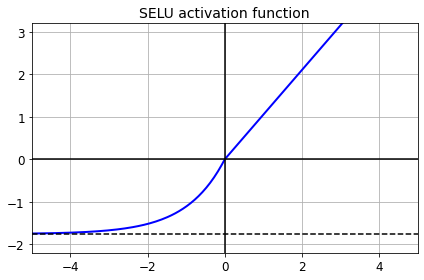

In [22]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

In [23]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [25]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

입력을 평균 0과 표준 편차 1로 바꾸어야 한다  
모든 은닉층의 가중치는 르쿤 정규분포 초기화로 초기화되어야한다  
네트워크는 일렬로 쌓은 층으로 구성되어야 한다.

In [26]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [27]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 40s 19ms/step - loss: 1.3441 - accuracy: 0.4731 - val_loss: 0.9538 - val_accuracy: 0.6240
Epoch 2/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.8016 - accuracy: 0.7019 - val_loss: 0.6694 - val_accuracy: 0.7610
Epoch 3/5
1719/1719 [==============================] - 30s 17ms/step - loss: 0.6512 - accuracy: 0.7675 - val_loss: 0.6520 - val_accuracy: 0.7750
Epoch 4/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.5808 - accuracy: 0.7994 - val_loss: 0.5353 - val_accuracy: 0.8206
Epoch 5/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.6082 - accuracy: 0.7942 - val_loss: 0.5476 - val_accuracy: 0.8190


### 11.1.3 배치 정규화

각 층에서 활성화 함수를 통과하기 전이나 후에 모델에 연산을 하나 추가한다.  
이 연산은 단순하게 입력을 원점에 맞추고 정규화한 다음, 각 층에서 두 개의 새로운 파라미터로 결괏값의 스케일을 조정하고 이동시킨다.

많은 경우 신경망의 첫 번째 층으로 배치 정규화를 추가하면 훈련세트를 표준화할 필요가 없다.(배치 정규화 층이 대신함)

학습 과정에서 Batch마다 평균과 분산을 활용하여 데이터의 분포를 정규화하는 과정  

장점  
- 데이터 Scale 통일
- 활성화 함수 맞춤형 분포 변화 가능

In [28]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense_108 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_109 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)              

새로운 Fixup 가중치 초기화 기법을 사용하여 배치 정규화 없이 훈련하는 방법도 나옴

### 11.1.4 그레디언트 클리핑

그래디언트 폭주 문제를 완화하는 방법은 일정 임계값을 넘어서지 못하게 그레디언트를 잘라내는 것  
순환 신경망은 배치 정규화를 적용하기 어려워서 이 방법을 많이 사용

In [30]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

이 옵티마이저는 그레디언트 벡터의 모든 원소를 -1과 1 사이로 클리핑(즉, 훈련되는 각 파라미터에 대한 손실의 모든 편미분 값을 -1과 1 사이로 자른다.)

실전에서는 잘 작동하는데, 그레디언트 벡터의 방향을 바꾸는 경우도 있다.  
이런 경우에는 clipnorm을 지정하여 노름으로 클리핑해야 한다.

In [31]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## 11.2 사전훈련된 층 재사용하기 (전이 학습)

훈련 속도를 크게 높일 뿐만 아니라 필요한 훈련 데이터도 크게 줄여준다.

### 11.2.1 케라스를 사용한 전이 학습

8개의 클래스만 담겨 있는 패션 MNIST 데이터 셋 (샌들과 셔츠를 제외한 클래스)  
누군가 이 데이터의 클래스를 분휴나는 모델 만들었다 -> 모델 A  
샌들과 셔츠를 구분하기 위한 작업 B를 위해 이진 분류기를 훈련하려고 함(양성=셔츠, 음성=샌들)  
레이블된 이미지는 겨우 200개로 매우 적음  
이를 위해 모델 A와 구조가 비슷한 모델 B를 만든다.

먼저 모델 A 로드하고, 이 모델의 층을 기반으로 새로운 모델 model_B_on_A를 만든다.  
출력층만 제외하고 모든 층을 재사용

In [3]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [4]:
X_train_A.shape, X_train_B.shape

((43986, 28, 28), (200, 28, 28))

In [5]:
tf.random.set_seed(42)
np.random.seed(42)

In [6]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [7]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [8]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 10s 5ms/step - loss: 0.5879 - accuracy: 0.8117 - val_loss: 0.3917 - val_accuracy: 0.8575
Epoch 2/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.3561 - accuracy: 0.8769 - val_loss: 0.3310 - val_accuracy: 0.8822
Epoch 3/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.3198 - accuracy: 0.8884 - val_loss: 0.3058 - val_accuracy: 0.8924
Epoch 4/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.3001 - accuracy: 0.8956 - val_loss: 0.2907 - val_accuracy: 0.8984
Epoch 5/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2866 - accuracy: 0.9006 - val_loss: 0.2805 - val_accuracy: 0.9058
Epoch 6/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2764 - accuracy: 0.9050 - val_loss: 0.2734 - val_accuracy: 0.9066
Epoch 7/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2679 - accuracy: 0.9075 - val_loss: 0.2701 - val_accuracy

In [9]:
model_A.save("my_model_A.h5")

C:\Users\junyoung\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [11]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [12]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 52ms/step - loss: 0.7479 - accuracy: 0.5600 - val_loss: 0.5816 - val_accuracy: 0.7059
Epoch 2/20
7/7 [==============================] - 0s 21ms/step - loss: 0.4742 - accuracy: 0.8150 - val_loss: 0.4281 - val_accuracy: 0.8641
Epoch 3/20
7/7 [==============================] - 0s 20ms/step - loss: 0.3532 - accuracy: 0.9300 - val_loss: 0.3416 - val_accuracy: 0.9199
Epoch 4/20
7/7 [==============================] - 0s 21ms/step - loss: 0.2829 - accuracy: 0.9450 - val_loss: 0.2858 - val_accuracy: 0.9391
Epoch 5/20
7/7 [==============================] - 0s 22ms/step - loss: 0.2374 - accuracy: 0.9550 - val_loss: 0.2467 - val_accuracy: 0.9533
Epoch 6/20
7/7 [==============================] - 0s 27ms/step - loss: 0.2037 - accuracy: 0.9700 - val_loss: 0.2177 - val_accuracy: 0.9594
Epoch 7/20
7/7 [==============================] - 0s 19ms/step - loss: 0.1792 - accuracy: 0.9700 - val_loss: 0.1976 - val_accuracy: 0.9655
Epoch 8/20
7/7 [===========

In [13]:
model_B.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 300)               235500    
                                                                 
 dense_7 (Dense)             (None, 100)               30100     
                                                                 
 dense_8 (Dense)             (None, 50)                5050      
                                                                 
 dense_9 (Dense)             (None, 50)                2550      
                                                                 
 dense_10 (Dense)            (None, 50)                2550      
                                                                 
 dense_11 (Dense)            (None, 1)                

In [14]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

model_A와 model_B_on_A 는 일부 층을 공유한다.  
model_B_on_A를 훈련할 때 model_A도 영향을 받는데, 이를 원치 않는다면 재사용하기 전에 model_A를 클론하면 된다.  
clone_model()로 모델 A의 구조를 복제한 후 가중치를 복사한다.

In [17]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

이제 작업 B를 위한 model_B_on_A를 훈련할 수 있지만, 새로운 출력층이 랜덤하게 초기화되어 있으므로 큰 오차를 만들 것이다.  
이는 큰 오차 그레디언트가 재사용된 가중치를 망칠 수 있기 때문에,  
처음 몇 번의 에포크 동안 재사용된 층을 동결하고 새로운 층에게 적절한 가중치를 학습할 시간을 주면 된다.  

In [18]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

In [19]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 49ms/step - loss: 0.2836 - accuracy: 0.8950 - val_loss: 0.2935 - val_accuracy: 0.8986
Epoch 2/4
7/7 [==============================] - 0s 21ms/step - loss: 0.2750 - accuracy: 0.9000 - val_loss: 0.2843 - val_accuracy: 0.9026
Epoch 3/4
7/7 [==============================] - 0s 30ms/step - loss: 0.2664 - accuracy: 0.9150 - val_loss: 0.2758 - val_accuracy: 0.9087
Epoch 4/4
7/7 [==============================] - 0s 29ms/step - loss: 0.2584 - accuracy: 0.9150 - val_loss: 0.2676 - val_accuracy: 0.9128
Epoch 1/16
7/7 [==============================] - 1s 48ms/step - loss: 0.2288 - accuracy: 0.9350 - val_loss: 0.2111 - val_accuracy: 0.9483
Epoch 2/16
7/7 [==============================] - 0s 24ms/step - loss: 0.1828 - accuracy: 0.9600 - val_loss: 0.1756 - val_accuracy: 0.9625
Epoch 3/16
7/7 [==============================] - 0s 23ms/step - loss: 0.1527 - accuracy: 0.9750 - val_loss: 0.1518 - val_accuracy: 0.9746
Epoch 4/16
7/7 [===============

In [20]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.0914 - accuracy: 0.9895


[0.09138517081737518, 0.9894999861717224]

In [21]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.0637 - accuracy: 0.9930


[0.06374137103557587, 0.9929999709129333]

### 11.2.2 비지도 사전훈련

레이블되지 않은 훈련 데이터를 많이 모을 수 있다면 오토인코더나 생성적 적대 신경망과 같은 비지도 학습 모델을 훈련할 수 있다.

## 11.3 고속 옵티마이저

표준적인 경사 하강법 옵티마이저 대신 더 빠른 옵티마이저를 사용할 수 있다.

### 11.3.1 모멘텀 최적화

이전 그레디언트가 얼마였는지를 고려하여 가중치를 갱신한다.  
그레디언트를 속도가 아니라 가속도로 사용하는 개념이다.

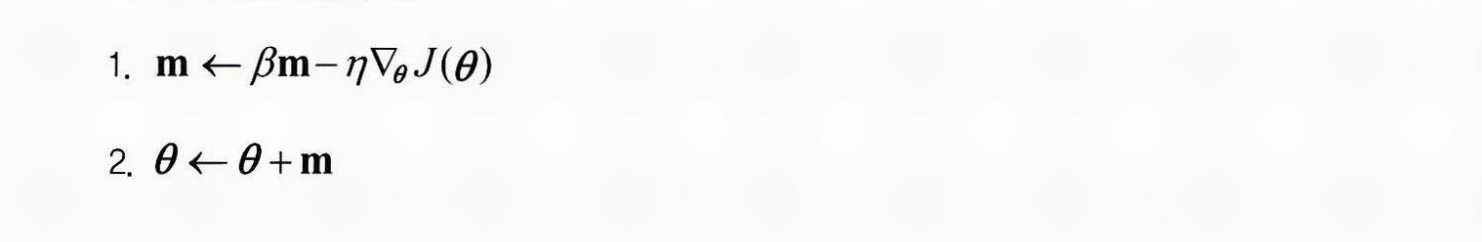

In [23]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

### 11.3.2 네스테로프 가속 경사

현재의 속도 벡터와 현재 속도로 한 걸음 미리 가 본 위치의 그레디언트 벡터를 더해 다음 위치를 정한다.  
(일반적으로 모멘텀 벡터가 올바른 방향을 가리킬 것이므로 이런 변경이 가능하다.)

오버슈팅을 막기 위해 현재 속도로 한 걸음 미리 가 보고 오버 슈팅이 된 만큼 다시 내리막길로 내려가는 방식

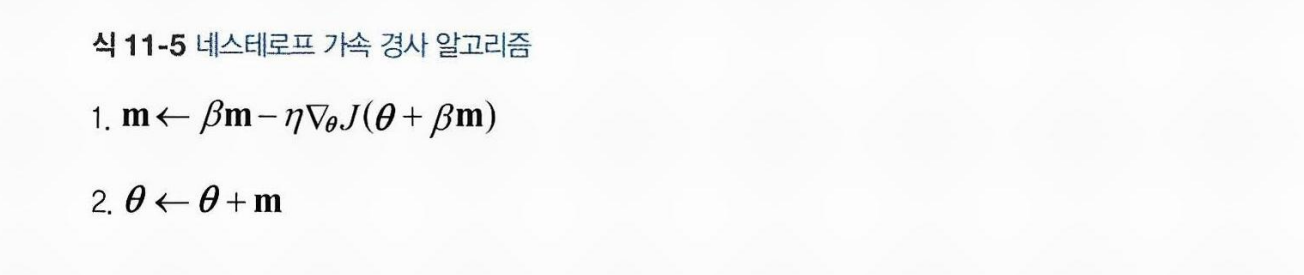

In [25]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

### 11.3.3 AdaGrad

손실 함수 곡면의 변화에 따라 적응적으로 학습률을 정하는 알고리즘으로,  
가장 가파른 차원을 따라 그레디언트 벡터의 스케일을 감소시킨다.

즉, 많이 변화한 변수는 최적해에 근접했을 거란 가정하에 작은 크기로 이동하면서 세밀하게 값을 조정하고 반대로 적게 변화한 변수들은 학습률을 크게 하여 빠르게 오차 값을 줄이고자 하는 방법

경사에 따른 보폭을 비교한다고 생각하면 쉬움

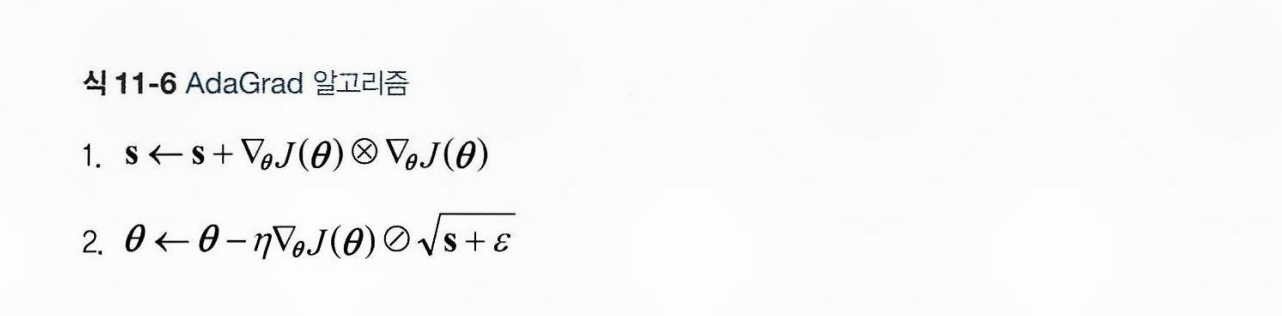

In [26]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

AdaGrad는 간단한 2차방정식 문제에서는 잘 작동하지만, 학습률이 너무 감소되어 전역 최적점에 도착하기 전에 조기 종료되는 경우가 발생한다.  
경사가 매우 가파른 곳에서 학습을 시작한다면, 초반부터 적응적 학습률이 급격히 감소하다가 최적해에 도착하기 전 조기 종료될 가능성이 있는 것이다.

### 11.3.4 RMSProp

가장 최근 반복에서 비롯된 그레디언트만 누적함으로써 AdaGrad의 문제를 해결

RMSProp의 장점은 미분값이 큰 곳에서는 업데이트 할 때 큰 값으로 나눠주기 때문에 기존 학습률 보다 작은 값으로 업데이트 됩니다.  
따라서 진동을 줄이는데 도움이 됩니다.  
반면 미분값이 작은 곳에서는 업데이트시 작은 값으로 나눠주기 때문에 기존 학습률 보다 큰 값으로 업데이트 됩니다.  
이는 조기 종료를 막으면서도 더 빠르게 수렴하는 효과를 불러옵니다.  
따라서 최근 경로의 gradient는 많이 반영되고 오래된 경로의 gradient는 작게 반영됩니다.  
gradient 제곱에 곱해지는 가중치가 지수승으로 변화하기 때문에 지수가중평균이라 부릅니다.  
매번 새로운 gradient 제곱의 비율을 반영하여 평균을 업데이트 하는 방식입니다.

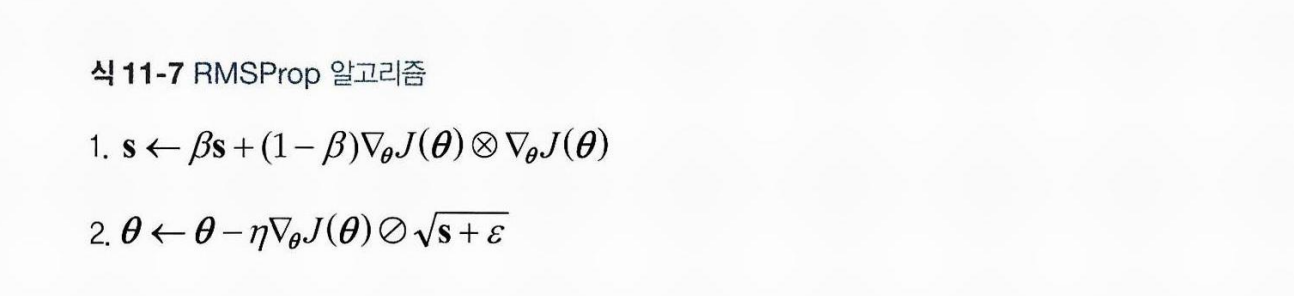

In [28]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

### 11.3.5 Adam과 Nadam 최적화

Adam은 Momentum과 RMSProp이 합쳐진 형태로, 진행하던 속도에 관성도 주고, 최근 경로의 곡면의 변화량에 따른 적응적 학습률을 갖는 알고리즘

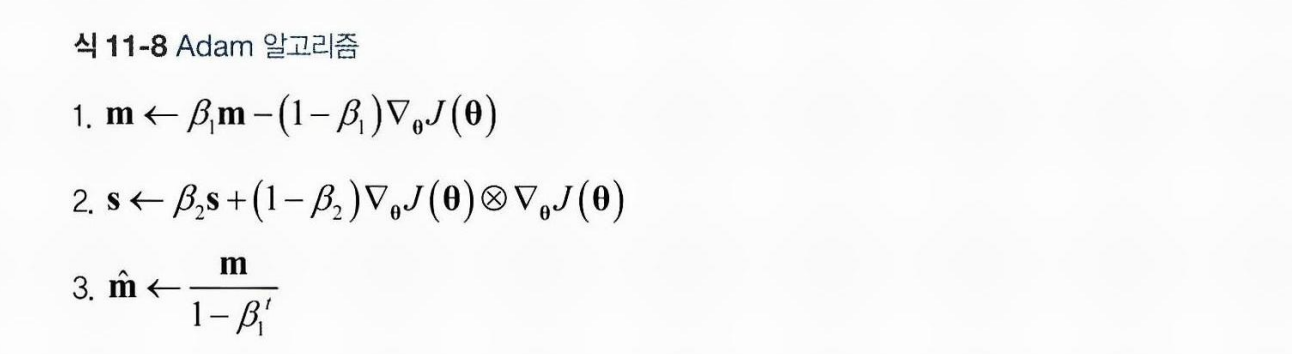
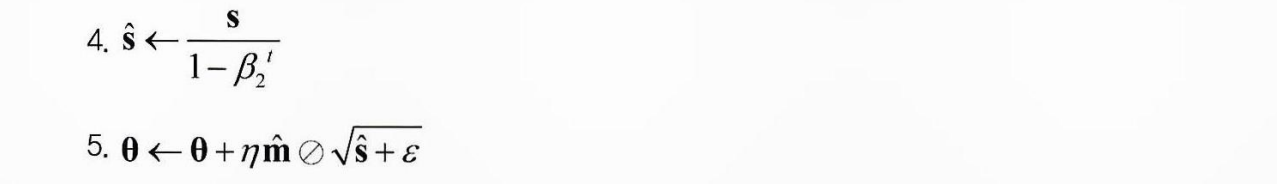

In [29]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

#### AdaMax

Adam의 2단계에서 s에 그레디언트 제곱을 누적한다.  
Adam보다 안정적이지만, 실제로 데이터셋에 따라 성능은 나쁠 수도 있다.

In [30]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

#### Nadam

Adam에 네스테로프 기법을 더한 것이다.  
Adam보다 조금 더 빠르게 수렴하기도 하고 다양한 옵티마이저를 적용하자~!

In [31]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

### 11.3.6 학습률 스케쥴링

큰 학습률로 시작하고 학습 속도가 느려질 때 학습률을 낮추면 최적의 고정 학습률보다 좋은 솔루션을 더 빨리 발견할 수 있습니다.

- 거듭제곱 기반 스케쥴링
- 지수 기반 스케쥴링
- 구간별 고정 스케쥴링
- 성능 기반 스케쥴링
- 1사이클 스케쥴링

**거듭제곱 기반 스케쥴링**  
lr = lr0 / (1 + steps / s)**c  

 Keras 옵티마이저에서 decay 매개변수가 더 이상 사용되지 않는다


keras.optimizers.schedules에ㅣ 있는 스케쥴 중에 하나를 사용해 학습률을 정의하고 이 학습률을 옵티마이저에 전달할 수 있다.  
이렇게 하면 에포크가 아니라 메 스텝마다 학습률을 업데이트한다.

In [36]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4887 - accuracy: 0.8282 - val_loss: 0.4020 - val_accuracy: 0.8580
Epoch 2/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3809 - accuracy: 0.8654 - val_loss: 0.3710 - val_accuracy: 0.8702
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3478 - accuracy: 0.8769 - val_loss: 0.3735 - val_accuracy: 0.8686
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3266 - accuracy: 0.8830 - val_loss: 0.3497 - val_accuracy: 0.8778
Epoch 5/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3112 - accuracy: 0.8896 - val_loss: 0.3442 - val_accuracy: 0.8742
Epoch 6/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2969 - accuracy: 0.8943 - val_loss: 0.3408 - val_accuracy: 0.8808
Epoch 7/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2869 - accuracy: 0.8980 - val_loss: 0.3362 - val_accuracy:

## 11.4 규제를 사용해 과대적합 피하기

높은 자유도는 네트워크를 훈련 세트에 과대적합되기 쉽게 한다

### 11.4.1 l1과 l2 규제

신경망의 연결 가중치를 제한하기 위해 l2규제를 사용하거나  
(많은 가중치가 0인) 희소 모델을 만들기 위해 l1규제를 사용할 수 있다.

케라스 층의 연결 가중치에 규제 강도 0.01을 사용하여 l2규제를 적용하는 방법

In [37]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

In [38]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 16s 8ms/step - loss: 1.5649 - accuracy: 0.8126 - val_loss: 0.7094 - val_accuracy: 0.8404
Epoch 2/2
1719/1719 [==============================] - 13s 8ms/step - loss: 0.7203 - accuracy: 0.8281 - val_loss: 0.6956 - val_accuracy: 0.8352


functools.partial() 함수를 사용하여 기본 매개변수 값을 사용하여 함수 호출을 감싸는 방법도 있다.

In [39]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 15s 7ms/step - loss: 1.6156 - accuracy: 0.8131 - val_loss: 0.7099 - val_accuracy: 0.8400
Epoch 2/2
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7226 - accuracy: 0.8266 - val_loss: 0.6887 - val_accuracy: 0.8362


### 11.4.2 드롭아웃

어떤 특정한 설명변수 Feature만을 과도하게 집중하여 학습함으로써 발생할 수 있는 과대적합(Overfitting)을 방지하기 위해 사용된다.

드롭아웃 비율 0.2를 사용한 드롭아웃 규제를 모든 Dense 층 이전에 적용한 코드

In [40]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 23s 11ms/step - loss: 0.5802 - accuracy: 0.8021 - val_loss: 0.3543 - val_accuracy: 0.8666
Epoch 2/2
1719/1719 [==============================] - 13s 7ms/step - loss: 0.4213 - accuracy: 0.8472 - val_loss: 0.3399 - val_accuracy: 0.8736


모델이 과적합되었다면 드롭아웃 비율을 늘려야하고, 과소적합되면 드롭아웃 비율을 낮춰야한다.  
층이 클 때는 드롭아웃 비율을 늘리고, 작은 층에는 드롭아웃 비율을 낮추는 것도 도움이 된다.  
또한 많은 최신 신경망 구조는 마지막 은닉층 뒤에만 드롭아웃을 사용하기도 한다.  

### 11.4.3 몬테 카를로 드롭아웃

- 예측과정에서 일반 dropout기법과는 다르게 dropout층을 활성화시키고, 테스트 셋의 100번 예측 결과를 만든다.  
- 드롭아웃으로 만든 예측을 평균하면 일반적으로 드롭아웃이 없이 예측한 하나의 결과보다 더 안정적인것을 확인할 수 있다.

In [60]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense_27 (Dense)            (None, 300)               235500    
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_28 (Dense)            (None, 100)               30100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_29 (Dense)            (None, 10)               

In [61]:
tf.random.set_seed(42)
np.random.seed(42)

In [62]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [63]:
np.round(model.predict(X_test_scaled[:1]), 2)

1/1 [==============================] - 0s 58ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.13, 0.  , 0.85]],
      dtype=float32)

In [64]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.56, 0.  , 0.39]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.32, 0.  , 0.67]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.22, 0.  , 0.77]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.04, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.15, 0.  , 0.75]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.52, 0.  , 0.38]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.21, 0.  , 0.07, 0.  , 0.72]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.22, 0.  , 0.72]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.97]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.13, 0.  , 0.82]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.04, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.16, 0.  , 0.25, 0.  , 0.59]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.11, 0.  , 0.84]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.01, 0.  , 0

In [65]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.18, 0.  , 0.75]],
      dtype=float32)

In [66]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.13, 0.02, 0.14]],
      dtype=float32)

In [67]:
y_pred = np.argmax(y_proba, axis=1)

In [68]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8598

모델이 훈련하는 동안 다르게 작동하는 (BatchNormalizatino 층과 같은) 층을 가지고 있다면,  
Dropout 층을 다음과 같은 MCDropout 클래스로 바꿔줘야 한다.

In [69]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

간단히 말해 MC 드롭아웃은 드롭아웃 모델의 성능을 높여주고 더 정확한 불확실성 추정을 제공한다.

### 11.4.4 맥스-노름 규제

In [70]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))